In [0]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from numpy import sqrt, log1p
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as MSE
import seaborn as sns
from sklearn.base import BaseEstimator
from sys import modules

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_colwidth', 10)

%matplotlib inline

This notebook includes a step-by-step For more details, see [Bike Sharing Demand][1] competition page on Kaggle.

[1]: https://www.kaggle.com/c/bike-sharing-demand "Bike Sharing Demand"

# Get the data

In [5]:
if 'google.colab' in modules:
    from google.colab import files
    uploaded = files.upload()
    

Saving test.csv to test.csv
Saving train.csv to train.csv


In [6]:
data = read_csv('train.csv', parse_dates=[0], index_col=0)
data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


First thing first... we split the data. We are allowed to learn ONLY from the train data!

In [0]:
train_data, test_data = \
    train_test_split(data, train_size=0.7, test_size=0.3, random_state=42)

> **NOTE:** Another option for splitting the data is by day-of-the-month, as it is more consistent with the problem definition. This can be achieved by applying user-defined split (using [PredefinedSplit][prsp]).

[prsp]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html "PredefinedSplit API"

## First impression

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7620 entries, 2011-02-08 17:00:00 to 2012-05-02 07:00:00
Data columns (total 11 columns):
season        7620 non-null int64
holiday       7620 non-null int64
workingday    7620 non-null int64
weather       7620 non-null int64
temp          7620 non-null float64
atemp         7620 non-null float64
humidity      7620 non-null int64
windspeed     7620 non-null float64
casual        7620 non-null int64
registered    7620 non-null int64
count         7620 non-null int64
dtypes: float64(3), int64(8)
memory usage: 714.4 KB


In [9]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,7620.0,2.509711,1.117478,1.00,2.0000,3.000,4.0000,4.0000
holiday,7620.0,0.029265,0.168560,0.00,0.0000,0.000,0.0000,1.0000
workingday,7620.0,0.683990,0.464948,0.00,0.0000,1.000,1.0000,1.0000
weather,7620.0,1.414567,0.630354,1.00,1.0000,1.000,2.0000,4.0000
temp,7620.0,20.252386,7.824203,0.82,13.9400,20.500,26.2400,41.0000
atemp,7620.0,23.670368,8.503034,0.76,16.6650,24.240,31.0600,45.4550
humidity,7620.0,61.893963,19.214918,0.00,47.0000,62.000,77.0000,100.0000
windspeed,7620.0,12.807253,8.203174,0.00,7.0015,12.998,16.9979,56.9969
casual,7620.0,35.803543,49.716591,0.00,4.0000,16.000,49.0000,362.0000
registered,7620.0,155.56...,151.72...,0.00,35.0000,118.000,223.0000,857.0000


For numeric-like features:

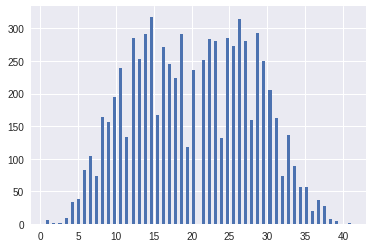

In [10]:
ax = train_data.temp.hist(bins=100)  
# temp / atemp / humidity / windspeed / registered / casual / count

For category-like features:

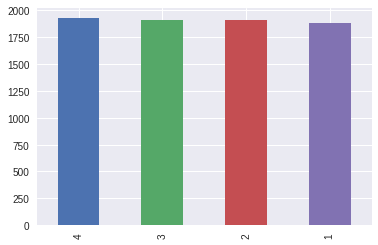

In [11]:
ax = train_data.season.value_counts().plot.bar()  
# season / holiday / workingday / weather

# Preprocessing - inspection and manipulation

## Time-related considerations

We are not dealing with time-series in our course, therefore the datetime should be exploded to its significant components. We add the *weekday* feature.

In [0]:
def explode_dt(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    return df

In [13]:
train_data = explode_dt(train_data)
train_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,weekday
datetime,,,,,,,,,,,,,,,
2011-02-08 17:00:00,1,0,1,1,9.02,9.090,32,39.0007,4,172,176,2011,2,17,1
2011-09-18 23:00:00,3,0,0,1,22.14,25.760,68,12.9980,10,44,54,2011,9,23,6
2011-08-19 04:00:00,3,0,1,1,26.24,28.790,83,0.0000,1,7,8,2011,8,4,4
2012-11-06 06:00:00,4,0,1,1,9.02,11.365,69,8.9981,6,143,149,2012,11,6,1
2011-04-05 11:00:00,2,0,1,3,13.12,14.395,81,30.0026,1,18,19,2011,4,11,1


**Thought:** Is the *year* important?

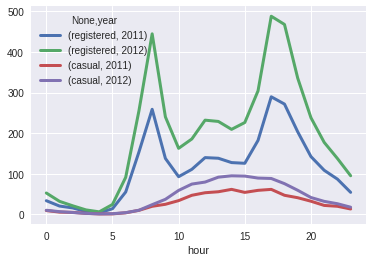

In [14]:
ax = train_data.groupby(['hour', 'year'])[['registered', 'casual']]\
    .mean().unstack().plot(lw=3)

**Conclusion:** There is a significant increase in the number of registered users in time. This is an important observation, but in this tutorial we will ignore this effect, and instead rely on the *year* data alone, which we will convert to 0's (for 2011) and 1's (for 2012).

In [0]:
train_data.year -= 2011

> An initial idea for how to look at the time-series data is illustrated below.

In [0]:
# import statsmodels.api as sm
# # Looking at rents of a speciffic day and hour
# rents = data.loc[(data.index.dayofweek==4) & (data.index.hour==14), 'count']
# # Using the Wald decomposition algorithm
# decomposed = sm.tsa.seasonal_decompose(rents, model='additive',
#                                        freq=7, two_sided=False).plot()

## Continuous features

Only 4 columns represent "measurement" data.

In [0]:
meas_cols = ['temp', 'atemp', 'humidity', 'windspeed']

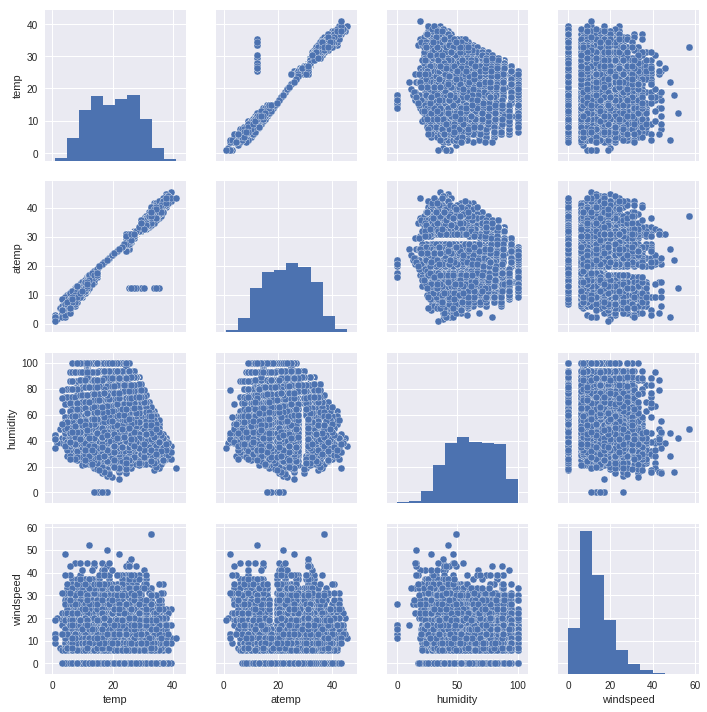

In [18]:
ax = sns.pairplot(train_data[meas_cols])

**Observations:**
* Missing values in windspeed
* Suspicious (outlier) data in atemp
* Weird (linear?) relation between temp and atemp

### Missing values in *windspeed*

In [19]:
train_data.windspeed.value_counts().sort_index().head(10)

0.0000     922
6.0032     630
7.0015     708
8.9981     761
11.0014    762
12.9980    733
15.0013    652
16.9979    595
19.0012    476
19.9995    336
Name: windspeed, dtype: int64

**Observations:** 
1. The windspeed data actually has integer values. There is nothing to do with this observation...
2. Values below 6 are missing. Next, we explore this further.

**Discussion: How should we impute the zeroes in *windspeed*?**

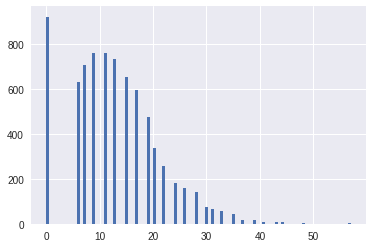

In [20]:
ax = train_data.windspeed.hist(bins=100)

There are 2 reasonable reasons for the (obviously problematic) 0's:
* **Meter error** - the meter is not sensitive enough, so anything below 6 m/h is truncated to 0. If this is the case, then it could be ignored, because it is reasonable to assume cyclists are not irritated by such a low wind.
* **System error** - we are concerned with the possibility that the missing values are at random due to some data collection problem (at the meter, at the communication, it doesn't really matter). In this case the 0's can actually stand for any value. If that's the case, then we should fix these values.

> **Note:** Another option is to drop records with 0 *windspeed*, but since it is a very common value, this is probably not a good idea.

**Thought:** The behaviour of the 0's over time would give us a hint about their nature.

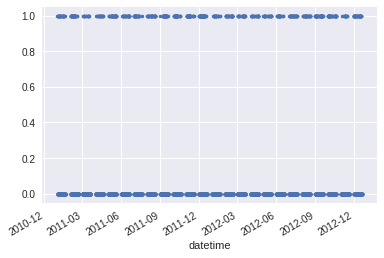

In [21]:
ax = (train_data.windspeed == 0).astype(int).plot(ls=' ', marker='.')

**Conclusion:** It seems like the 0's in *windspeed* are **systematic**, so they are probably not related to the actual weather.

We can impute the 0's using random forest regressor based on relevant data...

In [0]:
windspeed_rf = RandomForestRegressor(random_state=1234)
relevant_cols = ['season', 'weather', 'temp', 'humidity', 'hour', 'month']
X_windspeed = train_data[relevant_cols]
y_windspeed = train_data.windspeed

windspeed_ = pd.Series(windspeed_rf.fit(X_windspeed, y_windspeed)\
                       .predict(X_windspeed), 
                       index=train_data.index)

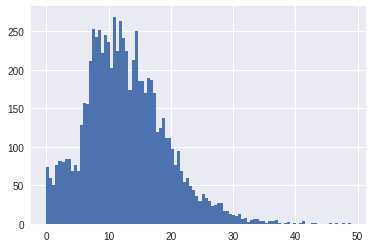

In [23]:
ax = windspeed_.hist(bins=100)

And just to be sure that the imputation is not that bad, we can estimate it using RMSE.

In [24]:
sqrt(MSE(train_data.windspeed, windspeed_))

3.3442376420838404

> **NOTE:** The regressor not only imputed the "missing data", but also "predicted" the non-missing data. We can change the entire *windspeed* data or we can impute only the "missing values".

In [0]:
train_data.loc[:, 'windspeed'] = windspeed_

### temp

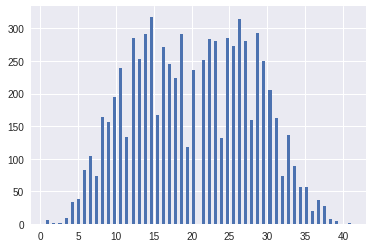

In [26]:
train_data.temp.hist(bins=100)

**Observation:** It is interesting to see the non-standard distribution, which means long winter and summer but shorter fall and spring.

**Conclusion:** We will drop *season*.

In [0]:
train_data.drop('season', axis=1, inplace=True)

In [28]:
train_data.head(5)

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,weekday
datetime,,,,,,,,,,,,,,
2011-02-08 17:00:00,0,1,1,9.02,9.090,32,35.700280,4,172,176,0,2,17,1
2011-09-18 23:00:00,0,0,1,22.14,25.760,68,8.667782,10,44,54,0,9,23,6
2011-08-19 04:00:00,0,1,1,26.24,28.790,83,0.899810,1,7,8,0,8,4,4
2012-11-06 06:00:00,0,1,1,9.02,11.365,69,10.398400,6,143,149,1,11,6,1
2011-04-05 11:00:00,0,1,3,13.12,14.395,81,30.101760,1,18,19,0,4,11,1


### Suspicious data in *atemp*

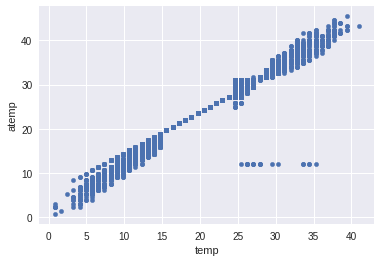

In [29]:
ax = train_data.plot.scatter(x='temp', y='atemp')

Let's zoom-in on the outliers.

In [30]:
train_data[(train_data.temp>20) & (train_data.atemp<20)].head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,weekday
datetime,,,,,,,,,,,,,,
2012-08-17 13:00:00,0,1,1,34.44,12.12,36,14.499470,103,254,357,1,8,13,4
2012-08-17 20:00:00,0,1,2,29.52,12.12,58,17.701400,97,262,359,1,8,20,4
2012-08-17 17:00:00,0,1,1,33.62,12.12,36,18.902040,144,647,791,1,8,17,4
2012-08-17 06:00:00,0,1,1,25.42,12.12,78,7.424103,6,151,157,1,8,6,4
2012-08-17 01:00:00,0,1,1,27.06,12.12,65,5.818838,16,38,54,1,8,1,4


**Conclusion:** Something went wrong on August 17th 2012, and we decide to remove these records from the **training** data.

In [0]:
train_data = train_data[~((train_data.temp>20) & (train_data.atemp<20))]

### Weird relation between temp and atemp

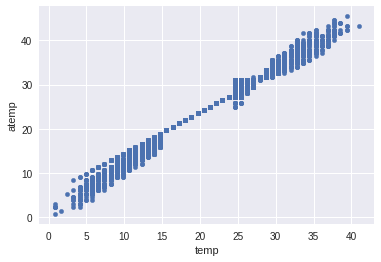

In [32]:
ax = train_data.plot.scatter(x='temp', y='atemp')

**Thoughts:** It is clear that *atemp* is very similar to *temp*, but it looks rather weird... We will drop this feature...

In [0]:
train_data.drop('atemp', axis=1, inplace=True)

> **Note:** This means that our previous outlier detection was unnecessary...

### Humidity

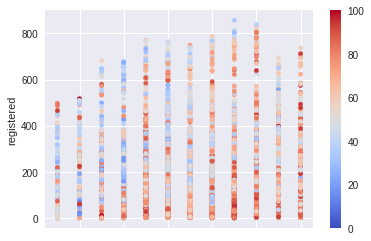

In [34]:
ax = train_data.plot.scatter(x='month', y='registered', 
                             c=train_data.humidity, cmap='coolwarm', s=20)

**Conclusion:** The humidity has very low influence for registered, but significant influence for casual cyclists. We will keep this feature as it is.

## Special days

### *workingday* and *holiday*

In [35]:
train_data.groupby(['workingday', 'holiday', 'weekday'])\
    ['registered', 'casual'].median()

registered  casual
workingday holiday weekday                    
0          0       5            103.0     27.0
                   6             89.0     25.0
           1       0             95.5     19.5
                   2            228.0    122.5
                   4             97.0     16.0
1          0       0            124.0     16.0
                   1            120.0     13.0
                   2            119.0     11.0
                   3            133.0     13.0
                   4            139.0     16.0

**Conclusion**: The days are workingday / weekends / holiday. In the US there are no religious holidays, so they are mutually exclusive.

**Alert:** What is going on with holidays on Monday?

In [36]:
train_data.loc[(train_data.workingday==0) & (train_data.weekday==2), 'casual']

datetime
2012-07-04 20:00:00    237
2012-07-04 21:00:00    222
2012-07-04 06:00:00      9
2012-07-04 14:00:00    190
2012-07-04 08:00:00     43
2012-07-04 23:00:00     31
2012-07-04 13:00:00    177
2012-07-04 17:00:00    161
2012-07-04 04:00:00      5
2012-07-04 11:00:00    164
2012-07-04 05:00:00      5
2012-07-04 22:00:00    175
2012-07-04 07:00:00     10
2012-07-04 15:00:00    155
2012-07-04 09:00:00     90
2012-07-04 03:00:00      9
Name: casual, dtype: int64

**Conclusion:** This data is made of outliers due to 4th of July (USA independence day), so we remove it from the **training** data.

In [0]:
july4th_ind = train_data.index.to_series()\
    .between('2012-07-04 00:00:00','2012-07-04 23:00:00')
train_data = train_data.loc[~july4th_ind]

**Thought:** Should we separate holiday & weekend? We will assume NOT for this analysis, so we drop *holiday*.

In [0]:
train_data.drop('holiday', axis=1, inplace=True)

### Rentals vs. *hour*

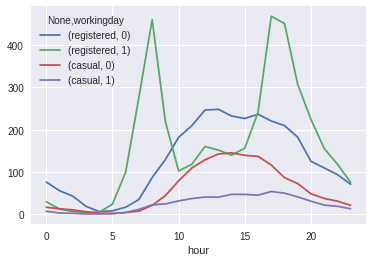

In [39]:
ax = train_data.groupby(['workingday', 'hour'])[['registered', 'casual']]\
    .mean().unstack(0).plot()

> **NOTE:** It is very important to notice the impact of *weekday* on the registered users. Compare the plot above with the one below, which does not groupby *weekday*.

In [0]:
# ax = train_data.groupby('hour')[['registered', 'casual']]\
#     .mean().plot()

**Observation:** Registered and casual users behave very differently in terms of workingday (weekday gives similar results) and hour. On working days, registered users rent bike in the rush hours (getting to and from work), but less during working hours, while on weekends everyone is biking during the day.

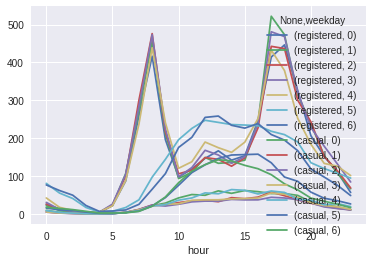

In [41]:
ax = train_data.groupby(['weekday', 'hour'])[['registered', 'casual']]\
    .mean().unstack(0).plot()

**Thought:** It looks like the actual weekday is not very important, besides the question whether it is a weekend or not. Since this information is already captured by the workingday columns, we decide to drop the weekday column.

In [0]:
train_data.drop('weekday', axis=1, inplace=True)

**<font color=red>Important Conclusion:</font>** We should make 4 different models for workingday/non-workingday and for registered/casual. We also note that some features should be dealt differently for different models (at least *hour*).

## Categorical features

The features *weather*, *month* and *hour* are basically categorical, and their processing depends on the chosen model.

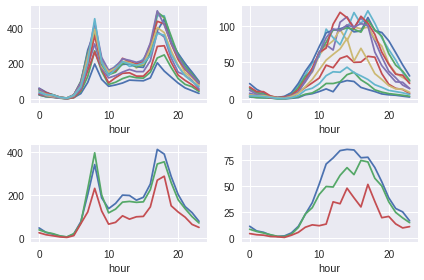

In [43]:
fig, axes = plt.subplots(2, 2, tight_layout=True);
train_data.groupby(['hour', 'month'])['registered']\
    .mean().unstack().plot(ax=axes[0][0], legend=None)
train_data.groupby(['hour', 'weather'])['registered']\
    .mean().unstack().plot(ax=axes[1][0], legend=None)
train_data.groupby(['hour', 'month'])['casual']\
    .mean().unstack().plot(ax=axes[0][1], legend=None)
train_data.groupby(['hour', 'weather'])['casual']\
    .mean().unstack().plot(ax=axes[1][1], legend=None)

**Alert:** The *weather* data should have 4 lines, but has only 3...

In [44]:
train_data.weather.value_counts()

1    5021
2    1979
3     584
4       1
Name: weather, dtype: int64

**Thought:** weather 4 is very rare, so we replace it with 3...

In [0]:
train_data.loc[train_data.weather==4, 'weather'] = 3

In [46]:
train_data.head()

,workingday,weather,temp,humidity,windspeed,casual,registered,count,year,month,hour
datetime,,,,,,,,,,,
2011-02-08 17:00:00,1,1,9.02,32,35.700280,4,172,176,0,2,17
2011-09-18 23:00:00,0,1,22.14,68,8.667782,10,44,54,0,9,23
2011-08-19 04:00:00,1,1,26.24,83,0.899810,1,7,8,0,8,4
2012-11-06 06:00:00,1,1,9.02,69,10.398400,6,143,149,1,11,6
2011-04-05 11:00:00,1,3,13.12,81,30.101760,1,18,19,0,4,11


# The 4 models

We are going to build 4 random forest regressors.

> **NOTE:** We will not train-test our 4 sub-models, but rely on cross-validation alone.

## Evaluation

In [0]:
def rmsle(y, y_pred):
    return sqrt(MSE(log1p(pd.Series(y_pred).clip_lower(0)), log1p(y)))

In [0]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## Model \#1 (*rw*) - Registered users on Working days

In [0]:
train_data_rw = train_data.loc[train_data.workingday==1]\
    .drop(['count', 'casual', 'workingday'], axis=1, inplace=False)

In [50]:
train_data_rw.head()

,weather,temp,humidity,windspeed,registered,year,month,hour
datetime,,,,,,,,
2011-02-08 17:00:00,1,9.02,32,35.700280,172,0,2,17
2011-08-19 04:00:00,1,26.24,83,0.899810,7,0,8,4
2012-11-06 06:00:00,1,9.02,69,10.398400,143,1,11,6
2011-04-05 11:00:00,3,13.12,81,30.101760,18,0,4,11
2012-08-01 15:00:00,1,33.62,46,12.880214,206,1,8,15


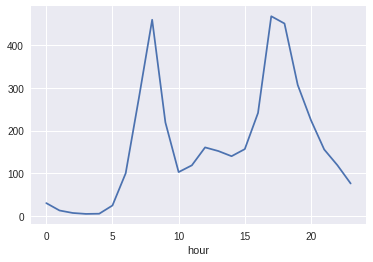

In [51]:
ax = train_data_rw.groupby('hour')['registered'].mean().plot(legend=None)

### Feature Engineering

#### *month* & *hour*

When applying trees it is very important to reduce the number of features, so it is better *NOT* to use dummy variables. Hence, we decide to keep *hour* and *month* numerical, hoping that the tree will join together natural sequences of months (e.g. March to May) and hours (e.g. 11-14).

> **Note:** An alternative approach would be to use many dummy variables, but then the number of feature increases, and other models would be more suitable (e.g. linear models & k-NN). An examplary code for this engineering is given below.

In [0]:
# def bin_hour(df):
#     df['hour'] = pd.cut(df.hour, bins=[0, 6, 9, 16, 19, 23], include_lowest=True, 
#                      labels=['midnight', 'morning rush', 'work', 'evening rush', 'evening'],)
#     return df 

# train_data_rw = pd.get_dummies(bin_hour(train_data_rw))

#### *weather*

*weather* has only 3 categories, and we can trust the model to separate them easily.

### Modelling

In [0]:
X_rw = train_data_rw.drop('registered', axis=1, inplace=False)
y_rw = train_data_rw['registered']

In [0]:
rw_model_rf = RandomForestRegressor(n_estimators=100, 
                                    max_features='auto', random_state=0)

**NOTE:** Random forests shine when their trees are over-fitted, so we will keep the over-fitting hyper-parameters of the internal trees (*max_depth*, *min_samples_split*, etc.).

In [0]:
scores = cross_val_score(estimator=rw_model_rf, X=X_rw, y=y_rw, 
                         cv=10, scoring=rmsle_scorer)

In [56]:
print(f'The mean of the scores is {scores.mean():.3}\n\
The standard deviation is {scores.std():.3}')

The mean of the scores is -0.332
The standard deviation is 0.0235


This looks like a promising model, so let's keep it :-)

In [57]:
rw_model_rf.fit(X=X_rw, y=y_rw)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

### Dimensionality reduction

Let's try to see if we can improve our model by removing unnecessary features. The problem at the moment is that *hour* is so important that it "shadows" the true relevancy of the other features. We can try to fit a model **without** *hour* and see if the importances change.

In [58]:
X_rw_no_hour = train_data_rw.drop(['registered', 'hour'], axis=1, inplace=False)
y_rw_no_hour = train_data_rw['registered']
rw_model_rf_no_hour = RandomForestRegressor(n_estimators=100, 
                                            max_features='auto', random_state=0)
rw_model_rf_no_hour.fit(X=X_rw_no_hour, y=y_rw_no_hour)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [59]:
imps_rw = pd.Series(rw_model_rf.feature_importances_, 
                    index=X_rw.columns, name='with hour')
imps_rw_no_hour = pd.Series(rw_model_rf_no_hour.feature_importances_, 
                            index=X_rw_no_hour.columns, name='without hour')
pd.concat([imps_rw, imps_rw_no_hour], axis=1).sort_values(by='without hour', ascending=False)

,with hour,without hour
windspeed,0.013379,0.350874
humidity,0.027737,0.224184
temp,0.043086,0.208520
month,0.062079,0.108023
year,0.089286,0.066281
weather,0.016123,0.042117
hour,0.748311,NaN


**Conclusion:** It seems like we could maybe drop the *weather* and *year* data.

In [60]:
X_rw_reduced = train_data_rw.drop(['registered', 'weather', 'year'], 
                                  axis=1, inplace=False)
y_rw_reduced = train_data_rw['registered']
rw_model_rf_reduced = RandomForestRegressor(n_estimators=100, random_state=0)
rw_model_rf_reduced.fit(X=X_rw_reduced, y=y_rw_reduced)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
scores = cross_val_score(estimator=rw_model_rf_reduced, 
                         X=X_rw_reduced, y=y_rw_reduced, 
                         cv=10, scoring=rmsle_scorer)

In [62]:
print(f'The mean of the scores is {scores.mean():.3}\n\
The standard deviation is {scores.std():.3}')

The mean of the scores is -0.434
The standard deviation is 0.0252


Well, we tried...

## Hyper-parameter optimization

In [0]:
param_grid = [{'max_features': [3, 5, 7], 'bootstrap': [True], 'oob_score': [True, False]},
              {'max_features': [3, 5, 7], 'bootstrap': [False], 'oob_score': [False]}]

In [0]:
rw_model_rf_gs = GridSearchCV(rw_model_rf, param_grid=param_grid, scoring=rmsle_scorer, cv=5)

In [65]:
rw_model_rf_gs.fit(X_rw, y_rw)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_features': [3, 5, 7], 'bootstrap': [True], 'oob_score': [True, False]}, {'max_features': [3, 5, 7], 'bootstrap': [False], 'oob_score': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=0)

In [0]:
best_params = rw_model_rf_gs.best_params_

In [0]:
scores = cross_val_score(estimator=rw_model_rf_gs.best_estimator_, 
                         X=X_rw, y=y_rw, cv=10, scoring=rmsle_scorer)

In [68]:
print(f'The mean of the scores is {scores.mean():.3}\n\
The standard deviation is {scores.std():.3}')

The mean of the scores is -0.327
The standard deviation is 0.0209


**And finally:**

In [0]:
rw_model_rf = rw_model_rf_gs.best_estimator_.fit(X_rw, y_rw)

## Model \#2 (*rn*) - Registered users on Non-working days

In [0]:
train_data_rn = train_data.loc[train_data.workingday==0]\
    .drop(['count', 'casual', 'workingday'], axis=1, inplace=False)

In [71]:
train_data_rn.head()

,weather,temp,humidity,windspeed,registered,year,month,hour
datetime,,,,,,,,
2011-09-18 23:00:00,1,22.14,68,8.667782,44,0,9,23
2012-12-02 07:00:00,2,9.84,93,7.398810,26,1,12,7
2011-10-16 21:00:00,1,22.14,52,27.002340,88,0,10,21
2011-10-09 06:00:00,1,18.04,88,0.700150,14,0,10,6
2012-04-16 02:00:00,1,24.60,64,15.399280,9,1,4,2


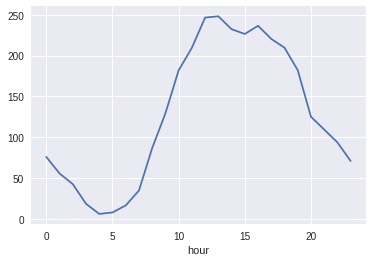

In [72]:
ax = train_data_rn.groupby('hour')['registered'].mean().plot(legend=None)

In [0]:
X_rn = train_data_rn.drop('registered', axis=1, inplace=False)
y_rn = train_data_rn['registered']

In [0]:
rn_model_rf = RandomForestRegressor(n_estimators=100, random_state=0, **best_params)

In [0]:
scores = cross_val_score(estimator=rn_model_rf, 
                         X=X_rn, y=y_rn, cv=10, scoring=rmsle_scorer)

In [76]:
print(f'The mean of the scores is {scores.mean():.3}\n\
The standard deviation is {scores.std():.3}')

The mean of the scores is -0.409
The standard deviation is 0.0221


## Model \#3 (*cw*) - Casual users on Working days

In [0]:
train_data_cw = train_data.loc[train_data.workingday==1]\
    .drop(['count', 'registered', 'workingday'], axis=1, inplace=False)

In [78]:
train_data_cw.head()

,weather,temp,humidity,windspeed,casual,year,month,hour
datetime,,,,,,,,
2011-02-08 17:00:00,1,9.02,32,35.700280,4,0,2,17
2011-08-19 04:00:00,1,26.24,83,0.899810,1,0,8,4
2012-11-06 06:00:00,1,9.02,69,10.398400,6,1,11,6
2011-04-05 11:00:00,3,13.12,81,30.101760,1,0,4,11
2012-08-01 15:00:00,1,33.62,46,12.880214,89,1,8,15


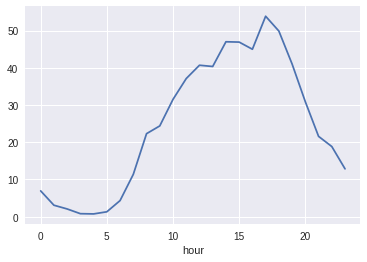

In [79]:
ax = train_data_cw.groupby('hour')['casual'].mean().plot(legend=None)

In [0]:
X_cw = train_data_cw.drop('casual', axis=1, inplace=False)
y_cw = train_data_cw['casual']

In [0]:
cw_model_rf = RandomForestRegressor(n_estimators=100, random_state=0, **best_params)

In [0]:
scores = cross_val_score(estimator=cw_model_rf, 
                         X=X_cw, y=y_cw, cv=10, scoring=rmsle_scorer)

In [83]:
print(f'The mean of the scores is {scores.mean():.3}\n\
The standard deviation is {scores.std():.3}')

The mean of the scores is -0.53
The standard deviation is 0.0224


## Model \#4 (*cn*) - Casual users on Non-working days

In [0]:
train_data_cn = train_data.loc[train_data.workingday==0]\
    .drop(['count', 'registered', 'workingday'], axis=1, inplace=False)

In [85]:
train_data_cn.head()

,weather,temp,humidity,windspeed,casual,year,month,hour
datetime,,,,,,,,
2011-09-18 23:00:00,1,22.14,68,8.667782,10,0,9,23
2012-12-02 07:00:00,2,9.84,93,7.398810,5,1,12,7
2011-10-16 21:00:00,1,22.14,52,27.002340,14,0,10,21
2011-10-09 06:00:00,1,18.04,88,0.700150,7,0,10,6
2012-04-16 02:00:00,1,24.60,64,15.399280,5,1,4,2


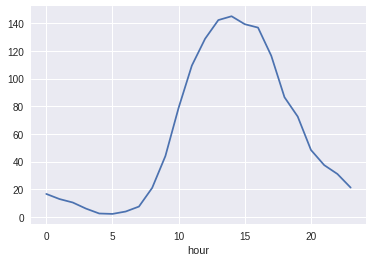

In [86]:
ax = train_data_cn.groupby('hour')['casual'].mean().plot(legend=None)

In [0]:
X_cn = train_data_cn.drop('casual', axis=1, inplace=False)
y_cn = train_data_cn['casual']

In [0]:
cn_model_rf = RandomForestRegressor(n_estimators=100, random_state=0, **best_params)

In [0]:
scores = cross_val_score(estimator=cn_model_rf, 
                         X=X_cn, y=y_cn, cv=10, scoring=rmsle_scorer)

In [90]:
print(f'The mean of the scores is {scores.mean():.3}\n\
The standard deviation is {scores.std():.3}')

The mean of the scores is -0.564
The standard deviation is 0.0291


# The final (additive) model

In [0]:
class ModelCombiner(BaseEstimator):
    def __init__(self, estimators):
        """estimators is a dictionary of estimators corresponding 
        to the keys {'RW', 'RN', 'CW', 'CN'}
        """
        self.estimators = estimators
        
    def fit(self, X, y=None):   
        """Here X includes 'count', registered' and 'casual'
        """
        # Model RW
        X_w = X.loc[X.workingday==1]\
            .drop(['count', 'casual', 'registered', 'workingday'], 
                  axis=1, inplace=False)
        y_rw = X.loc[X.workingday==1, 'registered']
        self.estimators['RW'].fit(X_w, y_rw)
        # Model CW
        X_w = X.loc[X.workingday==1]\
            .drop(['count', 'casual', 'registered', 'workingday'], 
                  axis=1, inplace=False)
        y_cw = X.loc[X.workingday==1, 'casual']
        self.estimators['CW'].fit(X_w, y_cw)        
        # Model RN
        X_n = X.loc[X.workingday==0]\
            .drop(['count', 'casual', 'registered', 'workingday'], 
                  axis=1, inplace=False)
        y_rn = X.loc[X.workingday==0, 'registered']
        self.estimators['RN'].fit(X_n, y_rn)        
        # Model CN
        X_n = X.loc[X.workingday==0]\
            .drop(['count', 'casual', 'registered', 'workingday'], 
                  axis=1, inplace=False)
        y_cn = X.loc[X.workingday==0, 'casual']
        self.estimators['CN'].fit(X_n, y_cn)
        
        return self
    
    def predict(self, X, y=None):
        """Here X does NOT include 'count', 'registered' and 'casual'
        """
        X_w = X.loc[X.workingday==1].drop(['workingday'], axis=1, inplace=False)
        X_n = X.loc[X.workingday==0].drop(['workingday'], axis=1, inplace=False)
        
        # Model RW
        y_rw_ = pd.Series(self.estimators['RW'].predict(X_w), 
                          index=X_w.index, name='RW')
        # Model RN
        y_rn_ = pd.Series(self.estimators['RN'].predict(X_n), 
                          index=X_n.index, name='RN')
        y_r_ = pd.concat([y_rw_, y_rn_], axis=0)
        
        # Model CW
        y_cw_ = pd.Series(self.estimators['CW'].predict(X_w), 
                          index=X_w.index, name='CW')
        # Model CN
        y_cn_ = pd.Series(self.estimators['CN'].predict(X_n), 
                          index=X_n.index, name='CN')
        y_c_ = pd.concat([y_cw_, y_cn_], axis=0)
        
        return y_r_ + y_c_

In [0]:
all4_model = ModelCombiner({'RW': rw_model_rf, 'RN': rn_model_rf, 
                            'CW': cw_model_rf, 'CN': cn_model_rf})

In [93]:
all4_model.fit(train_data)

ModelCombiner(estimators={'RW': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estim...n_estimators=100, n_jobs=1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)})

In [0]:
y_pred_train = all4_model\
    .predict(train_data.drop(['count', 'casual', 'registered'], 
                             axis=1, inplace=False))

In [95]:
y_pred_train.sort_index().head()

datetime
2011-01-01 01:00:00    36.29
2011-01-01 02:00:00    28.65
2011-01-01 04:00:00     3.54
2011-01-01 05:00:00     2.08
2011-01-01 06:00:00     3.56
dtype: float64

In [96]:
rmsle(y=train_data['count'].sort_index(), y_pred=y_pred_train.sort_index())

0.16387830478232782

# Validation

In [0]:
data = test_data
data = explode_dt(data)
data.year -= 2011

# Imuting windspeed
windspeed_rf = RandomForestRegressor(random_state=1234)
X_windspeed = data[['season', 'weather', 'temp', 'humidity', 'month', 'hour']]
y_windspeed = data.windspeed
windspeed_ = pd.Series(windspeed_rf.fit(X_windspeed, y_windspeed).predict(X_windspeed), 
                       index=data.index)
data.loc[:, 'windspeed'] = windspeed_

data.drop('season', axis=1, inplace=True)
data.drop('atemp', axis=1, inplace=True)
data.drop('holiday', axis=1, inplace=True)
data.drop('weekday', axis=1, inplace=True)

data.loc[data.weather==4, 'weather'] = 3

In [0]:
y_pred_test = all4_model\
    .predict(data.drop(['count', 'casual', 'registered'], 
                       axis=1, inplace=False))

In [99]:
rmsle(y=test_data['count'].sort_index(), y_pred=y_pred_test.sort_index())

0.3462492583212619

**Alert:** This result obviously means over-fitting...

# Submission

In [0]:
data = read_csv('test.csv', parse_dates=[0], index_col=0)
data = explode_dt(data)
data.year -= 2011

# Imuting windspeed
windspeed_rf = RandomForestRegressor(random_state=1234)
X_windspeed = data[['season', 'weather', 'temp', 'humidity', 'month', 'hour']]
y_windspeed = data.windspeed
windspeed_ = pd.Series(windspeed_rf.fit(X_windspeed, y_windspeed).predict(X_windspeed), 
                       index=data.index)
data.loc[:, 'windspeed'] = windspeed_

data.drop('season', axis=1, inplace=True)
data.drop('atemp', axis=1, inplace=True)
data.drop('holiday', axis=1, inplace=True)
data.drop('weekday', axis=1, inplace=True)

data.loc[data.weather==4, 'weather'] = 3

In [101]:
y_pred_submission = all4_model.predict(data).rename('count')
y_pred_submission.head()

datetime
2011-01-20 00:00:00    12.416
2011-01-20 01:00:00     5.120
2011-01-20 02:00:00     3.980
2011-01-20 03:00:00     2.745
2011-01-20 04:00:00     2.550
Name: count, dtype: float64

In [0]:
y_pred_submission.to_csv('submission.csv', header=True)

In [0]:
if 'google.colab' in modules:
    files.download('submission.csv')